# Proyecto aplicado: "Pokemon_data"
* Andrés Forero
* Daniel Cuellar
* Daniela González 




## Librerías 
______

In [38]:
# manejo de data
import pandas as pd
import numpy as np
import math
from scipy import stats
# visualización
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
sns.set_context("paper")
sns.set_style("whitegrid")

# Metodología CRISP-DM
___
<img src="http://www.iic.uam.es/wp-content/uploads/2021/11/CRISP-DM.jpg" width="400" height="400" />


## Situación actual


## Descripción del dataset
_______________


## Problema
_____


## Objetivos
_____

### General


### Específico 



## Hipótesis (científica o estadística)
------


# Entendimiento de los datos
----

## Carga De Datos


In [3]:
data = pd.read_csv("pokemon.csv")

## Describir los datos 


Este conjunto de datos contiene información sobre los 802 Pokémon de las Siete Generaciones de Pokémon, y el cual contiene las siguientes características.


* Name: El nombre en inglés del Pokémon.
* Japanese_name: El nombre japonés original del Pokémon
* Pokedex_number: El número de entrada del Pokémon en el Pokédex Nacional
* Percent_male: El porcentaje de las especies que son machos. En blanco si el Pokémon no tiene género.
* Type1: El tipo primario del Pokémon
* Type2: El tipo secundario del Pokémon
* Clasificación: La clasificación de los Pokémon como se describe en el Sol y la Luna Pokédex
* Height_m: Altura del Pokémon en metros
* Weight_kg: El Peso del Pokémon en kilogramos
* Capture_rate: Tasa de captura del Pokémon
* Base_egg_steps: La cantidad de pasos necesarios para eclosionar un huevo del Pokémon
* Abilities:Lista ordenada de habilidades que el Pokémon es capaz de tener.
* Experience_growth: Cantidad de puntos que obtiene un Pokémon al derrotar a otro en un combate y subir de nivel
* Base_happiness: Felicidad Base del Pokémon
* Against_?: Dieciocho características que denotan la cantidad de daño recibido contra un ataque de un tipo particular
* Base_total:Suma de las características del pokémon "attack", "defense", "hp", "sp_attack", "sp_defense" y "speed"
* HP: (Health Points) condición fisica del Pokémon, representada con un valor numérico
* Attack:El Ataque Base de los Pokémon
* Defense:La Defensa Base de los Pokémon
* Sp_attack: El Ataque Especial Base del Pokémon
* Sp_defense: La Defensa Especial Base del Pokémon
* Speed:La velocidad base del Pokémon
* Generation: Generación numerada en la que se introdujo por primera vez el Pokémon
* Is_legendary:Indica si el Pokémon es legendario.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   abilities          801 non-null    object 
 1   against_bug        801 non-null    float64
 2   against_dark       801 non-null    float64
 3   against_dragon     801 non-null    float64
 4   against_electric   801 non-null    float64
 5   against_fairy      801 non-null    float64
 6   against_fight      801 non-null    float64
 7   against_fire       801 non-null    float64
 8   against_flying     801 non-null    float64
 9   against_ghost      801 non-null    float64
 10  against_grass      801 non-null    float64
 11  against_ground     801 non-null    float64
 12  against_ice        801 non-null    float64
 13  against_normal     801 non-null    float64
 14  against_poison     801 non-null    float64
 15  against_psychic    801 non-null    float64
 16  against_rock       801 non

In [5]:
data.head()

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


## Limpieza de datos

Se valida que la variable "base_total" esta compuesta por la suma de las características "attack", "defense", "hp", "sp_attack", "sp_defense" y "speed"

In [ ]:
prueba_base=data['attack']+data['defense']+data['hp']+data['sp_attack']+data['sp_defense']+data['speed']
comparacion=prueba_base==data['base_total']
comparacion

### Valores nulos

In [6]:
nulos = data.isnull().sum(axis=0)
nulos[nulos>0]

height_m            20
percentage_male     98
type2              384
weight_kg           20
dtype: int64

Dado que hay solo 20 faltantes para height_m y weight_kg, se decide buscar la información faltante en una base externa [Pokédex](https://www.pokemon.com/el/pokedex).

In [7]:
data_missing= pd.read_csv("pokemons_faltantes.csv", sep=";")

data_missing.rename(columns={"weight_km":"weight_kg"})

,name,height_m,weight_kg
0,Rattata,0.3,3.5
1,Raticate,0.7,18.5
2,Raichu,0.8,30.0
3,Sandshrew,0.6,12.0
4,Sandslash,1.0,29.5
5,Vulpix,0.6,9.9
6,Ninetales,1.1,19.9
7,Diglett,0.2,0.8
8,Dugtrio,0.7,33.3
9,Meowth,0.2,0.8


In [8]:
data_missing= pd.read_csv("pokemons_faltantes.csv", sep=";")
data_missing.rename(columns={"weight_km":"weight_kg"})
df2=pd.merge(data_missing, data, on="name")
df2=df2.drop(["height_m_y", "weight_kg_y"], axis=1)
df2=df2.rename(columns={"weight_kg_x":"weight_kg", "height_m_x": "height_m"})
data_fix=data[data["weight_kg"].notna() ]
data_fix
a=data_fix.columns.tolist()
df2=df2[a]
data = pd.concat([data_fix,df2], axis=0)

In [9]:
nulos = data.isnull().sum(axis=0)
nulos[nulos>0]

percentage_male     98
type2              384
dtype: int64

### Sexo del pokémon

Se crea una columna adicional para el porcentaje de sexo femenino, por ende, para los pokemón que no poseen sexo, se dejan en 0 las 2 columnas de sexo.

In [10]:
data["percentage_female"]= [ 0 if pd.isna(i) else 100-i for i in data.percentage_male]
data["percentage_male"]=data["percentage_male"].fillna(0)

### Ajuste de tasa de captura

In [11]:
data.capture_rate.unique()

array(['45', '255', '120', '90', '190', '235', '150', '25', '170', '50',
       '75', '200', '100', '180', '60', '225', '30', '35', '3', '65',
       '70', '127', '125', '205', '155', '145', '130', '140', '15', '220',
       '160', '80', '55', '30 (Meteorite)255 (Core)'], dtype=object)

In [12]:
data.loc[data.capture_rate=='30 (Meteorite)255 (Core)',"capture_rate"]=30

data['capture_rate'] = data['capture_rate'].astype(int)

### Descarte de variables

Se descartan las siguientes variables:
* abilitites: están fuera del alcance.
* classfication: no provee mucha información.
* japanese_name: se va a trabajar con el nombre en inglés "name".
* pokedex_number: al ser un índice no da información adicional.
* type2: la mayoría de registros son de 1 solo tipo por ende se deja fuera del alcance.

In [13]:
datos = data.loc[:,~data.columns.isin(["abilities","classfication","japanese_name","pokedex_number","type2"])]

## Estadística exploratoria
------

In [14]:
categorical_data = data.select_dtypes(include=['object']).columns
def est_exploratoria(data,categoricas):
    """
    tablas de estadística exploratoria
    ---
    data : dataframe
    categoricas : lista con nombre de variables a tratar como categoricas
    
    """
    datos = data.loc[:,~data.columns.isin(categoricas)]

    df0 = datos.agg([lambda x : sum(x.isna()),"count",]).rename(index={"<lambda>": 'Na count'})
    df1 = datos.agg(["mean"])
    df2 = datos.agg(pd.Series.mode).loc[[0]].rename(index={0: 'mode'})
    df3 = datos.agg(["median","std","var","kurt","skew","max","min"])

    df = pd.concat([df0,df1,df2, df3])

    df["Measurement"] = df.index
    df["Type"]=["Structure","Structure","Central t.","Central t.","Central t.","Dispersion","Dispersion","Shape","Shape","Range","Range"]
    df.set_index("Type", append=False, inplace=True)
    df.set_index("Measurement", append=True, inplace=True)

    numerica=df.round(decimals=2)

    datos = data.loc[:,data.columns.isin(categoricas)]


    df0 = datos.agg([lambda x : sum(x.isna())]).rename(index={"<lambda>": 'Na count'})

    df = pd.concat([df0,datos.describe(include=['object',"string"])])

    categorica=df.round(decimals=2)
    return numerica, categorica

numerica, categorica = est_exploratoria(datos,categorical_data)

numerica


against_bug  against_dark  against_dragon   
Type       Measurement                                              
Structure  Na count            0.00          0.00            0.00  \
           count             801.00        801.00          801.00   
Central t. mean                1.00          1.06            0.97   
           mode                1.00          1.00            1.00   
           median              1.00          1.00            1.00   
Dispersion std                 0.60          0.44            0.35   
           var                 0.36          0.19            0.12   
Shape      kurt                5.00          5.41            4.45   
           skew                1.76          1.72            0.00   
Range      max                 4.00          4.00            2.00   
           min                 0.25          0.25            0.00   

                        against_electric  against_fairy  against_fight   
Type       Measurement                                                   
Structure  Na count                 0.00           0.00           0.00  \
           count                  801.00         801.00         801.00   
Central t. mean                     1.07           1.07           1.07   
           mode                     1.00           1.00           1.00   
           median                   1.00           1.00           1.00   
Dispersion std                      0.65           0.52           0.72   
           var                      0.43           0.27           0.51   
Shape      kurt                     2.11           9.83           2.68   
           skew                     0.93           2.48           1.26   
Range      max                      4.00           4.00           4.00   
           min                      0.00           0.25           0.00   

                        against_fire  against_flying  against_ghost   
Type       Measurement                                                
Structure  Na count             0.00            0.00           0.00  \
           count              801.00          801.00         801.00   
Central t. mean                 1.14            1.19           0.99   
           mode                 1.00            1.00           1.00   
           median               1.00            1.00           1.00   
Dispersion std                  0.69            0.60           0.56   
           var                  0.48            0.37           0.31   
Shape      kurt                 3.75            5.06           2.03   
           skew                 1.61            1.77           0.45   
Range      max                  4.00            4.00           4.00   
           min                  0.25            0.25           0.00   

                        against_grass  ...  height_m      hp  percentage_male   
Type       Measurement                 ...                                      
Structure  Na count              0.00  ...      0.00    0.00             0.00  \
           count               801.00  ...    801.00  801.00           801.00   
Central t. mean                  1.03  ...      1.16   68.96            48.41   
           mode                  1.00  ...      0.60   60.00            50.00   
           median                1.00  ...      1.00   65.00            50.00   
Dispersion std                   0.79  ...      1.07   26.58            26.22   
           var                   0.62  ...      1.15  706.28           687.31   
Shape      kurt                  4.59  ...     43.85    8.33            -0.03   
           skew                  1.97  ...      5.12    1.83            -0.33   
Range      max                   4.00  ...     14.50  255.00           100.00   
           min                   0.25  ...      0.10    1.00             0.00   

                        sp_attack  sp_defense   speed  weight_kg  generation   
Type       Measurement                                                         
Structure  Na count      

In [15]:
categorica

,name,type1
Na count,0,0
count,801,801
unique,801,18
top,Bulbasaur,water
freq,1,114


## Visualización de datos
------

In [16]:
contras=datos[datos.columns[
    (pd.Series(datos.columns).str.startswith('against')) | 
    (datos.columns=="type1")]].groupby(["type1"]).agg("mean")

contras.head()


,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,against_ground,against_ice,against_normal,against_poison,against_psychic,against_rock,against_steel,against_water
type1,,,,,,,,,,,,,,,,,,
bug,0.826389,0.979167,0.937500,1.138889,0.916667,0.458333,2.194444,2.083333,1.013889,0.420139,0.562500,1.208333,0.930556,0.930556,1.159722,2.291667,0.972222,1.020833
dark,1.724138,0.534483,1.103448,1.103448,2.275862,1.965517,1.034483,1.034483,0.551724,0.775862,0.965517,1.206897,0.931034,0.913793,0.000000,1.241379,1.000000,1.000000
dragon,0.944444,1.037037,2.000000,0.490741,2.111111,0.925926,0.509259,1.055556,1.074074,0.527778,0.925926,2.518519,1.000000,0.925926,1.037037,1.111111,1.000000,0.592593
electric,0.871795,1.000000,0.897436,0.538462,0.948718,1.064103,1.102564,0.474359,0.974359,0.910256,2.051282,1.025641,0.923077,0.935897,0.948718,1.025641,0.500000,1.000000
fairy,0.472222,0.500000,0.000000,1.111111,1.000000,0.472222,1.000000,1.000000,1.000000,0.944444,0.888889,1.111111,1.000000,2.000000,1.000000,1.111111,2.000000,1.000000


In [17]:
import plotly.express as px
fig = px.imshow(contras,
                labels=dict(x="From", y="Type", color="Damage Received"),
                color_continuous_scale='Jet',title="Daño recibido según tipo de pokemón")
fig.update_layout(width=1000, height=900,template='plotly_white')
fig.show()

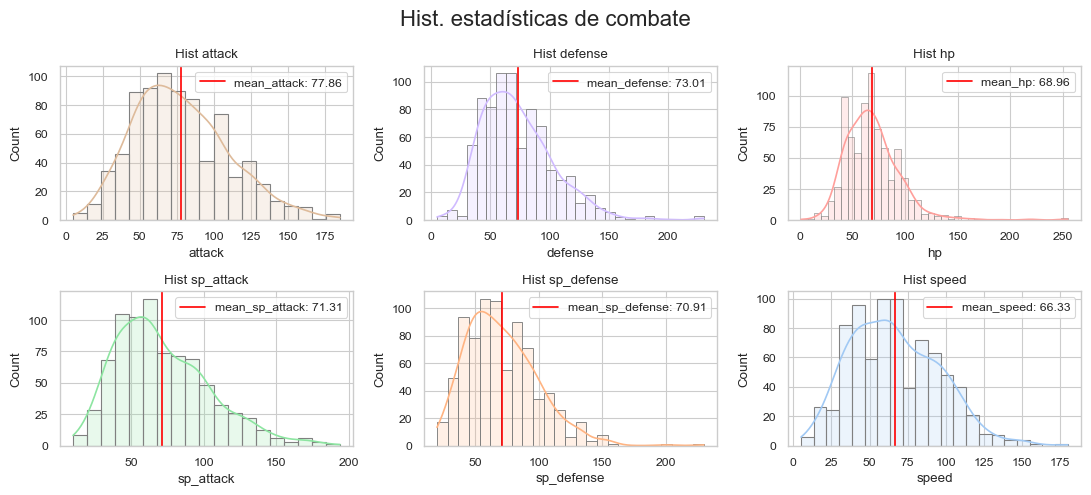

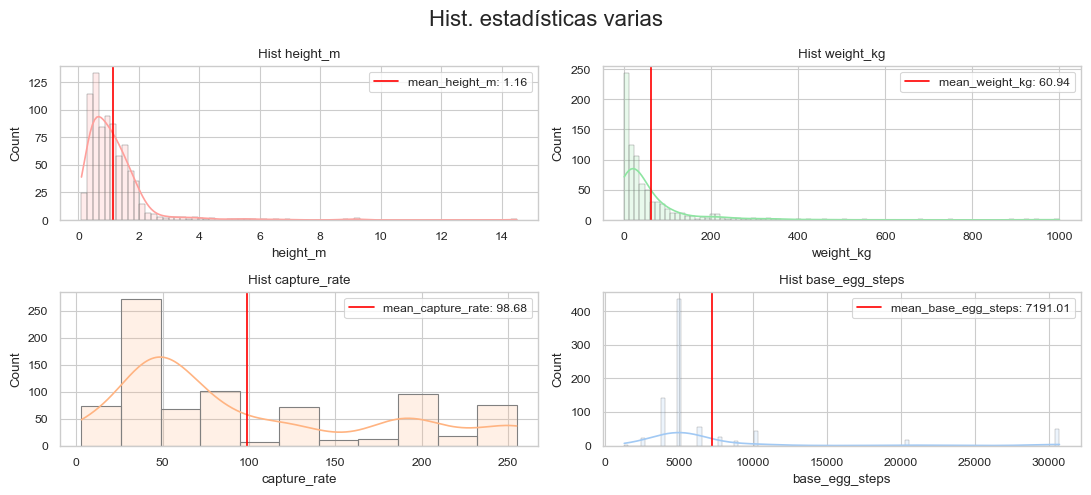

In [18]:
combat_stats = ['attack','defense','hp','sp_attack', 'sp_defense','speed']
other_stats = ['height_m', 'weight_kg','capture_rate','base_egg_steps']

def plot_stats(datos,listado,titulo):
    n_rows=2
    n_cols=math.ceil(len(listado)/2)

    fig,ax = plt.subplots(nrows=n_rows,ncols=n_cols,figsize=(11,5))
    count=0
    palette = list(reversed(sns.color_palette("pastel", len(listado)).as_hex()))

    class salida(Exception): pass

    try: 
        for i in range(n_rows):
            for j in range(n_cols):
                # print(i,j)
                sns.histplot(datos[listado[count]], kde=True,color=palette[count],alpha=0.2,edgecolor="gray",ax=ax[i,j])
                # ax[i,j].hist(datos[listado[count]],color=palette[count])
                ax[i,j].axvline([datos[listado[count]].mean()],color="red",label=f"mean_{listado[count]}: {round(datos[listado[count]].mean(),2)}")
                ax[i,j].legend()
                ax[i,j].title.set_text(f'Hist {listado[count]}')

                count+=1
                if count==len(listado): raise salida

    except salida:
        None




    fig.suptitle(titulo, fontsize=16)
    fig.tight_layout()


plot_stats(datos,combat_stats,"Hist. estadísticas de combate")
plot_stats(datos,other_stats,"Hist. estadísticas varias")

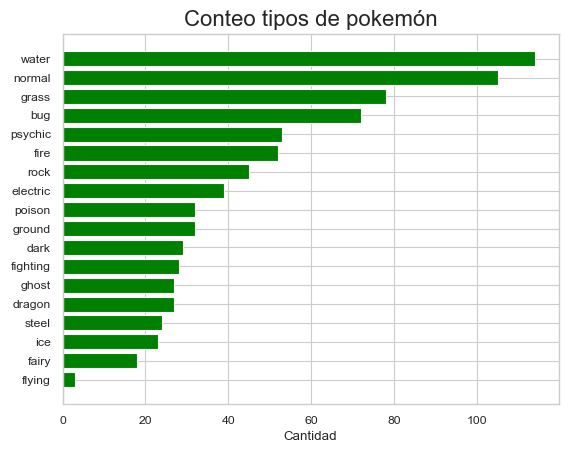

In [19]:
type1_counts = datos["type1"].value_counts().sort_values()
fig, ax = plt.subplots()
ax.barh(type1_counts.index, type1_counts.values, color='green')
ax.set_title("Conteo tipos de pokemón",fontsize=16)
ax.set_xlabel("Cantidad")
plt.show()


# DANIEL 
* Boxplot variables por tipo y legendario

## Filtros


Dados los diferentes alcances del proyecto se realizarán filtros para tener conjuntos de datos apropiados para los análisis posteriores.

No supervisado: 
* agrupar pokemones con características similares

Supervisados:
* clasificador el tipo de pokémon
* clasificador si es legendario


In [24]:
datos = datos.loc[:,~datos.columns.isin(["name"])]

# Análisis de datos
___

## Pruebas de correlación



In [42]:
data_corr = datos.select_dtypes(include=['int','float64'])

def tabla_corr_pearson(data_fixed,alfa,umbral):
  newdf = data_fixed.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
  result = []


  for i in newdf.columns:
    for j in newdf.columns:
      if i!=j:
        coef, p = stats.pearsonr(newdf[i], newdf[j])
        result.append([i,j,coef,p < alfa,p])

  correlaciones = pd.DataFrame(result,columns=["Var_i","Var_j","Coef_corr","Correlacionada","p_value"])


  return correlaciones[(correlaciones.Correlacionada==True) & (abs(correlaciones.Coef_corr)>=umbral)].drop_duplicates(["Coef_corr","p_value"])


tabla_corr_pearson(data_corr,0.05,0.65)

,Var_i,Var_j,Coef_corr,Correlacionada,p_value
41,against_dark,against_ghost,0.672337,True,1.792426e-106
632,attack,base_total,0.730134,True,2.774246e-134
678,base_egg_steps,is_legendary,0.873488,True,5.424174e-252
735,base_total,capture_rate,-0.712275,True,5.908588e-125
741,base_total,sp_attack,0.741120,True,2.107866e-140
742,base_total,sp_defense,0.717434,True,1.416538e-127


___

___

___

# 3 Transforme las variables categóricas y continuas en variables que entienda el modelo de predicción.

Recuerde tener en cuenta si las variables son categóricas (nominales, ordinales) o numéricas (discretas, continuas).

https://medium.com/hugo-ferreiras-blog/dealing-with-categorical-features-in-machine-learning-1bb70f07262d

- TargetEncoding
- LabelEncoding
- OneHotEncoding
- CategoricalEncoding


# 3.1 Realice un preprocesamiento de los datos.
Con esto se pretende ver si llevando los datos a un espacio de menor dimensionalidad impacta al modelo. Se debe entrenar el modelo con los datos crudos y con los datos preprocesados.

- Estandarizar (Min Max Scaler)
- Normalizar (StandarScaler)
- Reducir dimensionalidad (PCA, t-sne, umap,  random-projections, feature agglomeration u otras) ¿Qué pasa si aplico reducción de dimensionalidad y qué pasa si no lo aplico?

- Quitar datos atípicos (estrategias, media, variaza, clipping) 

Una libreria recomendada es Missingno
 
https://towardsdatascience.com/using-the-missingno-python-library-to-identify-and-visualise-missing-data-prior-to-machine-learning-34c8c5b5f009

- Transformaciones personalizadas (mean encoding, categorical encoding, label encoding)

https://towardsdatascience.com/custom-transformers-in-python-part-ii-6fe111fc82e4

# DANIELA 4. Grafique los datos con pairplot 

Cargue alguna libreria para hacer las graficas más amigables

# DANIELA 4.1 ¿Qué puede extraer de los datos con esta gráfica?

Muestra todas las combinaciones de la información existente de tipo numérico o float

# 5. Particione los datos en entrenamiento y prueba

Verifique que tipo de partición debe realizar, ya que sus datos pueden ser de tipo series de tiempo

`train_test_split`

Rucuerden que en el caso de serie de tiempo es recomendable utilizar `shuffle=false`

También recuerde que en el caso de datos desbalanceados es recomendable utilizar estratificación.


# 6. Partione en subconjunto de entrenamiento y validación

Particione sus datos en entrenamiento y validación para la busqueda de hiperparámetros. Recuerde que puede utilizar otras estrategias como k-fold o one-hold-out

# 7. Realice el escalamiento o normalización que requieran los datos

Rucuerden que el escalamiento se realiza el fit en entrenamiento y el transform tanto en entrenamiento como pueba

# 8. Métodos no supervisados de agrupacion

La idea en este punto es probar varios métodos no supervisados. 

Posibles métodos:

- K-means
- Kmedoids
- Spectral Clustering
- DbScan
- Tsne
- Affinity Propagation

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster

https://scikit-learn.org/stable/modules/clustering.html#clustering

## Métricas:

- Intrinsecas (inercia, coeficiente silueta)
- Extrinsecas (Matriz Contingencia, homogeneidad, completez, v-score, f1-score, indice rand, )

# 8. Métodos supervisados

Posibles métodos:

- SVM
- Random Forest
- Gradient Boosting Descent
- Naive Bayes
- Knn
- Redes neuronales

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.neural_network

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.kernel_approximation

Métricas:

- Clasificación

  - Accuracy
  - Precision (Macro, Micro, Average)
  - Recall (Macro, Micro, Average)
  - F1-Score (Macro, Micro, Average)
  - Sensitivity
  - Auc-PR
  - Auc-ROC
  - Matriz de confusión

- Regresión:

  - MSE (mean squared error)
  - RMSE (root mean squared erro)
  - Log MSE
  - MAE( mean average error)
  - R^2

Metodología para encontrar hiperparametros con grid search cv o random search cv

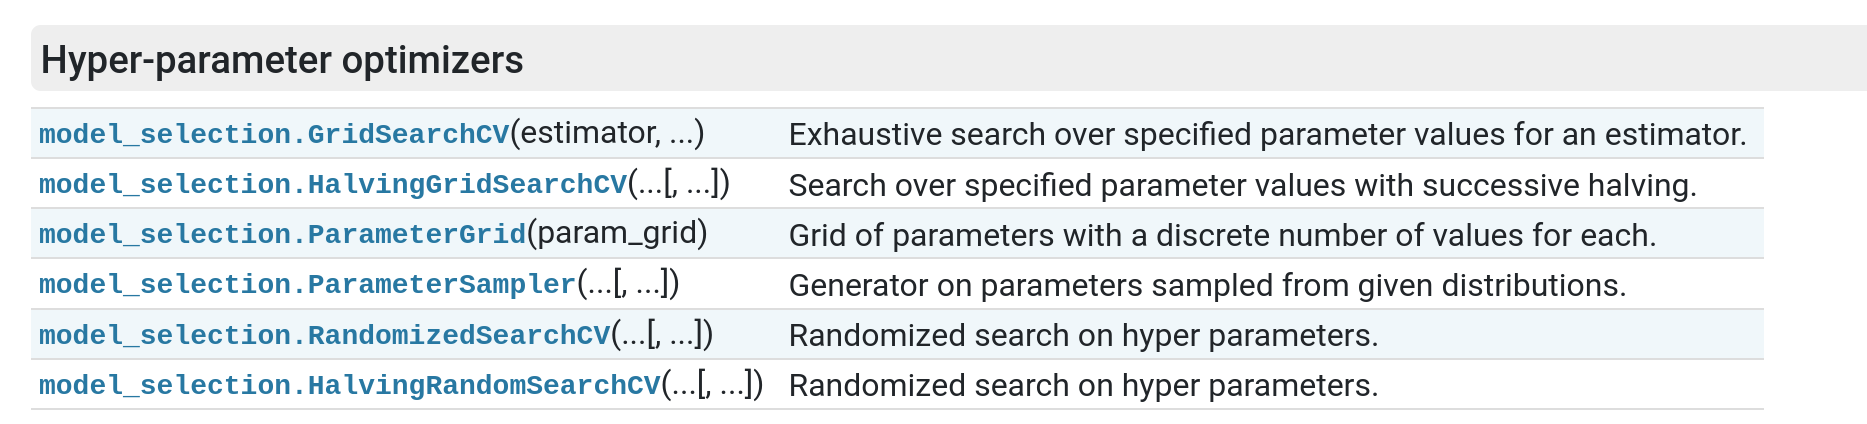

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

## ¿Cuál fue el mejor algoritmo que funcionó para sus datos?

## ¿Por qué cree que fue el que mejor funcionó?
## ¿Qué otras técnicas cree que puede utilizar para mejorar su algoritmo?

## ¿Los métodos aplicados le ayudaron a responder sus preguntas con base en los datos? Trate de mostrar gráficamente la información extraida del proceso.
## ¿Le hicieron falta datos?, realice una conjetura sobre como podría obtener mejores resultados.